# Select events from catalogue and save to individual file

_This version does not rely on the Basemap package_

In [1]:
%matplotlib notebook
from __future__ import print_function, division

In [2]:
import database
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import statsmodels.api as sm
from math import cos, asin, sqrt
import os
import pickle

from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.lines import Line2D

import cartopy.crs as ccrs
import cartopy.feature as feature
import shapely.geometry as sg


from netCDF4 import Dataset

from Utilities.config import ConfigParser
from Utilities.lmomentFit import samlmu, pelgev, pelgpa
from Utilities.track import ncReadTrackData

# Import widgets for interactive notebook
from ipywidgets import interact, fixed, FloatSlider, Dropdown, interact_manual
import ipywidgets as widgets

from IPython.display import display

import seaborn as sns
sns.set_context("poster")
sns.set_style("whitegrid")

/home/547/cxa547/venv/notebooks/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
def makeSegments(xx, yy):
    points = np.array([xx, yy]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    return segments

def colorline(ax, xdata, ydata, zdata=None, alpha=0.9):
    colours=['0.75', '#0FABF6', '#0000FF', 
             '#00FF00', '#FF8100', '#ff0000']
    intervals = [0, 17.5, 24.5, 32.5, 44.2, 55.5, 1000]
    intervals = [800, 920, 935, 950, 970, 985, 1050]
    segments = makeSegments(xdata, ydata)
    cmap = ListedColormap(colours[::-1])
    norm = BoundaryNorm(intervals, cmap.N)
    lc = LineCollection(segments, array=zdata, cmap=cmap,
                        norm=norm, alpha=alpha)

    labels = ['No data', 'Category 1', 'Category 2',
              'Category 3', 'Category 4', 'Category 5']
    handles = []
    for c, l in zip(cmap.colors, labels[::-1]):
        handles.append(Line2D([0], [0], color=c, label=l))

    ax.add_collection(lc)
    ax.legend(handles, labels[::-1], loc=2, frameon=True, prop={'size': 10})

def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295
    a = 0.5 - np.cos((lat2-lat1)*p)/2 + np.cos(lat1*p)*np.cos(lat2*p) * (1-np.cos((lon2-lon1)*p)) / 2
    return 12742 * np.arcsin(np.sqrt(a))

def loadTrack(trackId):
    trackNum, trackYear = int(trackId.split('-')[0]), int(trackId.split('-')[1])
    trackFile = os.path.join(outputPath, 'tracks', 'tracks.{0:05d}.nc'.format(trackYear))
    tracks = ncReadTrackData(trackFile)
    
    return [t for t in tracks if t.trackId==(trackNum, trackYear)][0]

def getTracks(recs):
    tracks = []
    for rec in recs:
        trackId = rec['eventId']
        track = loadTrack(trackId)
        tracks.append(track)
    return tracks

def plot_tracks(gridLimit, tracks):
    '''
    Plot all of the tracks contained within the 'tracks' object
    '''
    fig = plt.figure(figsize=(12,6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(resolution='10m', color='black', linewidth=1)
    ax.add_feature(feature.BORDERS)
    gl = ax.gridlines(linestyle=":", draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    if gridLimit['xMax'] > 180:
        ax.set_xlim((gridLimit['xMin']-360, gridLimit['xMax']-360))
    else:
        ax.set_xlim((gridLimit['xMin'], gridLimit['xMax']))
    ax.set_ylim((gridLimit['yMin'], gridLimit['yMax']))
    for track in tracks:
        if gridLimit['xMax'] > 180:
            colorline(ax, track.Longitude-360., track.Latitude, track.CentralPressure)
        else:
            colorline(ax, track.Longitude, track.Latitude, track.CentralPressure)
        ax.hold(True)
    return fig, ax


In [4]:
working_dir = '/g/data/w85/cek156/db10kyr'
configFile = os.path.join(working_dir, 'tcrm2.0.ini')
#working_dir = '/g/data/w85/TCRM_data/tonga/'
#configFile = os.path.join(working_dir, 'tonga.201711130757.ini')
configFile

'/g/data/w85/cek156/db10kyr/tcrm2.0.ini'

In [5]:
config = ConfigParser()
config.read(configFile)

db = database.HazardDatabase(configFile)
locations = db.getLocations()
locNameList = list(locations['locName'])
outputPath = config.get('Output', 'Path')
gridLimit = config.geteval('Region', 'gridLimit')

In [31]:
# Set up the thresholds for the different TC categories
TC_thresholds = {'Category 1': 30, 'Category 3': 50, 'Category 4': 60, 'Category 5': 80}

In [7]:
l = Dropdown(options=locNameList, description="Location")
display(l)

The installed widget Javascript is the wrong version.


In [35]:
locName = l.value
locId = locations['locId'][locations['locName']==locName][0]
locLon = locations['locLon'][locations['locId']==locId][0]
locLat = locations['locLat'][locations['locId']==locId][0]

events = database.locationRecords(db, locId)
locpt = sg.Point(locLon, locLat)

In [10]:
def filter_events(category, distance):
    extreme_events = [e for e in events if e['wspd'] > category]
    print(len(extreme_events))
    tracks = getTracks(extreme_events)
    tracks = [t for t in tracks if t.minimumDistance([locpt]) < distance]
    extremedf = pd.DataFrame.from_records(extreme_events, columns=events.dtype.names)
    print("There are {0} events that pass within {1} km of {2}".format(len(tracks), distance, locName))
    return extremedf, tracks

Update the category and maximum distance here to filter the collection of events. 

In [36]:
distance = 50
category = "Category 1"
extremedf, tracks = filter_events(TC_thresholds[category], distance)

606
There are 53 events that pass within 50 km of Geraldton Airport


<IPython.core.display.Javascript object>


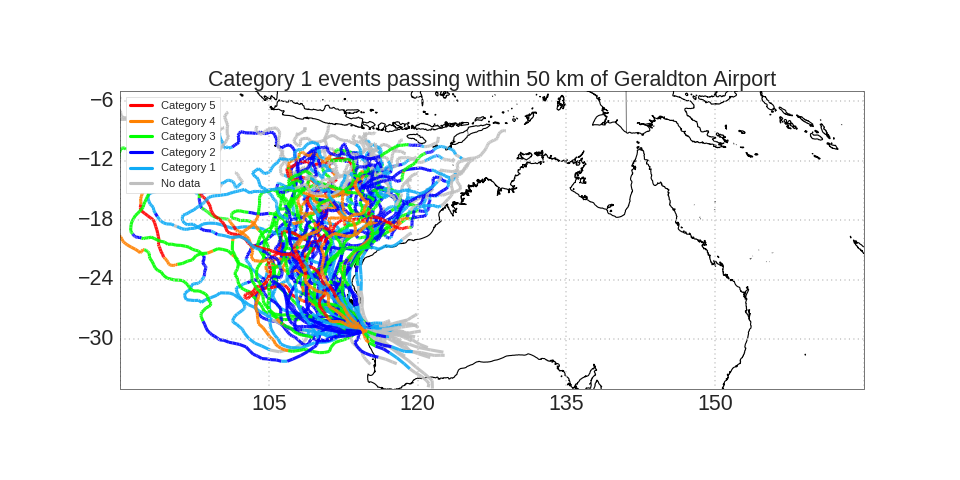

The installed widget Javascript is the wrong version.


In [37]:
fig, ax = plot_tracks(gridLimit, tracks)  
ax.scatter(locpt.x, locpt.y, color='k', s=20)
ax.set_title("{0} events passing within {1} km of {2}".format(category.capitalize(),
                                                           distance, locName))
w = widgets.HTML("Click on the track you would like to identify")
def onclick(event):
    global Lon, Lat
    Lon, Lat = event.xdata, event.ydata
    w.value = 'Lon: {}, Lat: {}'.format(Lon, Lat) 
cid = fig.canvas.mpl_connect('button_press_event', onclick)
display(w)

Here we determine which track was the closest to the point that we clicked on, and give the details of the event below.

In [ ]:
Diffs = []
for track in tracks:
    if gridLimit['xMax'] > 180:
        min_val = min(abs(Lon - (track.Longitude - 360.)) + abs(Lat - track.Latitude))
    else:
        min_val = min(abs(Lon - track.Longitude) + abs(Lat - track.Latitude))
    Diffs.append(min_val)
ix = Diffs.index(min(Diffs))
first, second = tracks[ix].trackId
first = str(first).zfill(3)
second = str(second).zfill(5)
eventid = '{0}-{1}'.format(first, second)

chosen = extremedf[extremedf['eventId'] == eventid]
chosen

Now retrieve the wind field for the selected event, and the single track, so it can be plotted. 

In [ ]:
gust_filename = '{0}/windfield/gust.{1}.nc'.format(working_dir, str(chosen['eventId'].values[0]))
nc = Dataset(gust_filename)
lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
vmax = nc.variables['vmax'][:][:]

trackYear = str(chosen['eventId'].values[0]).split('-')[1]
trackfile = '{0}/tracks/tracks.{1}.nc'.format(working_dir, trackYear)
eventTrack = getTracks(chosen.to_records())[0]


In [ ]:
palette = [(1.000, 1.000, 1.000), (0.000, 0.627, 0.235), (0.412, 0.627, 0.235), (0.663, 0.780, 0.282),
        (0.957, 0.812, 0.000), (0.925, 0.643, 0.016), (0.835, 0.314, 0.118),
        (0.780, 0.086, 0.118)]
cmap = sns.blend_palette(palette, as_cmap=True)

fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m', color='grey', linewidth=1)
ax.add_feature(feature.BORDERS)
plt.scatter(locpt.x, locpt.y, color='k', s=200)
colorline(ax, eventTrack.Longitude, eventTrack.Latitude, eventTrack.CentralPressure)
gl = ax.gridlines(linestyle=":", draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False

ax.set_xlim((gridLimit['xMin'], gridLimit['xMax']))
ax.set_ylim((gridLimit['yMin'], gridLimit['yMax']))
plt.contourf(lon, lat, vmax, 60, cmap=cmap, transform=ccrs.PlateCarree())
plt.title('Modelled max gust windfield for {0} event {1}, near {2}'.format(category, str(chosen['eventId'].values[0]), 
                                                                           str(chosen['locName'].values[0])), size=12)
ax.set_xlabel('Longitude', fontsize = 10)
ax.set_ylabel('Latitude', fontsize = 10)
cl = plt.colorbar(ax=ax, label="Windspeed (m/s)")
cl.ax.tick_params(labelsize=10)

plt.show()

In [ ]:
from Utilities.track import ncSaveTracks
ncTrack = eventTrack
scenarioTrackFile = os.path.join(os.getcwd(), 'track.{0}.nc'.format(str(chosen['eventId'].values[0])))
print("Saving track data to {0}".format(scenarioTrackFile))
ncSaveTracks(scenarioTrackFile, [ncTrack], calendar='julian')

In [14]:
import Utilities.shapefile as shapefile
from itertools import izip
import numpy as np

TCRMFIELD_NAMES = ('CycloneNumber', 'TimeElapsed', 
                   'Longitude', 'Latitude', 'Speed', 'Bearing', 'pCentre', 'pEnv', 'rMax', 'Year', 'Month', 'Day', 'Hour', 'Minute', )
TCRMFIELD_TYPES = ("N",)*14
TCRMFIELD_WIDTH = (2, 6, 7, 7, 6, 6, 7, 7, 6, 4, 2, 2, 2, 2)
TCRMFIELD_PRECS = (0, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0)

TCRMFIELDS = [[n, t, w, p] for n, t, w, p in zip(TCRMFIELD_NAMES,
                                                 TCRMFIELD_TYPES,
                                                 TCRMFIELD_WIDTH,
                                                 TCRMFIELD_PRECS)]

def recdropfields(rec, names):
    names = set(names)
    newdtype = np.dtype([(name, rec.dtype[name]) for name in rec.dtype.names
                       if name not in names])

    newrec = np.recarray(rec.shape, dtype=newdtype)
    for field in newdtype.names:
        newrec[field] = rec[field]

    return newrec

def mytracks2line(tracks, outputFile, dissolve=False):
    """
    Writes tracks to a shapefile as a collection of line features

    If dissolve==True, then each track feature is written as a
    single polyline feature, otherwise each track segment is
    stored as a separate feature.

    :type  tracks: list of :class:`Track` objects
    :param tracks: :class:`Track` features to store in a shape file

    :type  outputFile: str
    :param outputFile: Path to output file destination

    :type  dissolve: boolean
    :param dissolve: Store track features or track segments.

    :raises: :mod:`shapefile.ShapefileException` if there is an error
             when attempting to save the file.
    """
    #LOG.info("Writing line shape file: {0}".format(outputFile))
    sf = shapefile.Writer(shapefile.POLYLINE)
    sf.fields = TCRMFIELDS
    #if dissolve:
    #    sf.fields = EVENTFIELDS
    #else:
    #    sf.fields = OBSFIELDS

    #LOG.debug("Processing {0} tracks".format(len(tracks)))

    for track in tracks:
        track.data = recdropfields(track.data, ['Datetime'])
        if dissolve:
            if len(track.data) > 1:
                dlon = np.diff(track.Longitude)
                if dlon.min() < -180:
                    # Track crosses 0E longitude - split track
                    # into multiple parts:
                    idx = np.argmin(dlon)
                    parts = []
                    lines = izip(track.Longitude[:idx],
                                 track.Latitude[:idx])

                    parts.append(lines)
                    lines = izip(track.Longitude[idx+1:],
                                 track.Latitude[idx+1:])

                    parts.append(lines)
                    sf.line(parts)
                else:
                    lines = izip(track.Longitude, track.Latitude)
                    sf.line([lines])
            else:
                lines = izip(track.Longitude, track.Latitude)
                sf.line([lines])


            minPressure = track.trackMinPressure
            maxWind = track.trackMaxWind

            age = track.TimeElapsed.max()

            startYear = track.Year[0]
            startMonth = track.Month[0]
            startDay = track.Day[0]
            startHour = track.Hour[0]
            startMin = track.Minute[0]
            record = [track.CycloneNumber[0], startYear, startMonth, startDay,
                      startHour, startMin, age, minPressure, maxWind]
            sf.record(*record)

        else:
            if len(track.data) == 1:
                line = [[[track.Longitude, track.Latitude],
                        [track.Longitude, track.Latitude]]]
                sf.line(line)
                sf.record(*track.data[0])
            else:
                for n in range(len(track.data) - 1):
                    dlon = track.Longitude[n + 1] - track.Longitude[n]
                    if dlon < -180.:
                        # case where the track crosses 0E:
                        segment = [[[track.Longitude[n], track.Latitude[n]],
                                    [track.Longitude[n], track.Latitude[n]]]]
                    else:
                        segment = [[[track.Longitude[n],
                                     track.Latitude[n]],
                                    [track.Longitude[n + 1],
                                     track.Latitude[n + 1]]]]
                    sf.line(segment)
                    sf.record(*track.data[n])

                # Last point in the track:
                sf.line([[[track.Longitude[n + 1],
                           track.Latitude[n + 1]],
                              [track.Longitude[n + 1],
                               track.Latitude[n + 1]]]])
                sf.record(*track.data[n+1])

    try:
        sf.save(outputFile)
    except shapefile.ShapefileException:
        print("Cannot save shape file: {0}".format(outputFile))
        raise
        
        
def add_field(a, descr):
    if a.dtype.fields is None:
        raise ValueError, "`A' must be a structured numpy array"
    b = np.empty(a.shape, dtype=a.dtype.descr + descr)
    for name in a.dtype.names:
        b[name] = a[name]
    return b

In [ ]:
eventTrack = tracks #getTracks(chosen.to_records())[0]
eventTrack.data = add_field(eventTrack.data, [('Year', int), ('Month', int), ('Day', int), ('Hour', int), ('Minute', int)])

for rec in eventTrack.data:
    rec['Year'] = rec['Datetime'].year
    rec['Month'] = rec['Datetime'].month
    rec['Day'] = rec['Datetime'].day
    rec['Hour'] = rec['Datetime'].hour
    rec['Minute'] = rec['Datetime'].minute
    rec['Longitude'] = rec['Longitude']- 360.



In [ ]:
#from Utilities.tracks2shp import tracks2point, tracks2line
pt_shpfile = os.path.join(os.getcwd(), 'track.{0}.shp'.format(str(chosen['eventId'].values[0])))
line_shpfile = os.path.join(os.getcwd(), 'track.{0}.line.shp'.format(str(chosen['eventId'].values[0])))
line_prjfile = os.path.join(os.getcwd(), 'track.{0}.line.prj'.format(str(chosen['eventId'].values[0])))
#tracks2point([eventTrack], pt_shpfile)
mytracks2line([eventTrack], line_shpfile)


prjwkt = "GEOGCS['GCS_GDA_1994',DATUM['D_GDA_1994',SPHEROID['GRS_1980',6378137.0,298.257222101]],PRIMEM['Greenwich',0.0],UNIT['Degree',0.0174532925199433]]"
prjfh = open(line_prjfile, 'w')
prjfh.write(prjwkt)
prjfh.close()

These next couple of cells are for where you know the eventIds that you want to convert to shapefiles. Edit the `eventList` variable and then run the cells

In [ ]:
allEvents = database.selectEvents(db)

eventList = ['000-01322', '013-00928', '000-06481', '003-03693', 
             '012-06287', '012-03435', '006-00850', '009-07603']
eventdf = pd.DataFrame.from_records(allEvents, columns=allEvents.dtype.names)

chosen = eventdf[eventdf['eventId'].isin(eventList)]

In [ ]:
chosen

In [ ]:
eventdf

In [ ]:
eventdf[0:10].to_records()

In [38]:
#tracks = getTracks([e for e in eventdf.to_records()])
for t in tracks:
    t.data = add_field(t.data, [('Year', int), ('Month', int), ('Day', int), 
                                                  ('Hour', int), ('Minute', int)])

    for rec in t.data:
        rec['Year'] = rec['Datetime'].year
        rec['Month'] = rec['Datetime'].month
        rec['Day'] = rec['Datetime'].day
        rec['Hour'] = rec['Datetime'].hour
        rec['Minute'] = rec['Datetime'].minute
        rec['Longitude'] = rec['Longitude']
        
line_shpfile = os.path.join(os.getcwd(), 'Geraldton_tracks_line.shp')
mytracks2line(tracks, line_shpfile)
    

In [ ]:
for event in eventdf[0:10].to_records():
    eventTrack = getTracks([event])[0]
    eventTrack.data = add_field(eventTrack.data, [('Year', int), ('Month', int), ('Day', int), 
                                                  ('Hour', int), ('Minute', int)])

    for rec in eventTrack.data:
        rec['Year'] = rec['Datetime'].year
        rec['Month'] = rec['Datetime'].month
        rec['Day'] = rec['Datetime'].day
        rec['Hour'] = rec['Datetime'].hour
        rec['Minute'] = rec['Datetime'].minute
        rec['Longitude'] = rec['Longitude']
        
    line_shpfile = os.path.join(os.getcwd(), 'track.{0}.line.shp'.format(str(event['eventId'])))
    mytracks2line([eventTrack], line_shpfile)
    

In [ ]:
trackIds = ['{0:03d}-{1:05d}'.format(*t.trackId) for t in tracks]
chosen = extremedf[extremedf['eventId'].isin(trackIds)]

In [ ]:
for event in chosen.to_records():
    eventTrack = getTracks([event])[0]
    eventTrack.data = add_field(eventTrack.data, [('Year', int), ('Month', int), ('Day', int), 
                                                  ('Hour', int), ('Minute', int)])

    for rec in eventTrack.data:
        rec['Year'] = rec['Datetime'].year
        rec['Month'] = rec['Datetime'].month
        rec['Day'] = rec['Datetime'].day
        rec['Hour'] = rec['Datetime'].hour
        rec['Minute'] = rec['Datetime'].minute
        rec['Longitude'] = rec['Longitude']
        
    line_shpfile = os.path.join(os.getcwd(), 'track.{0}.line.shp'.format(str(event['eventId'])))
    line_prjfile = os.path.join(os.getcwd(), 'track.{0}.line.prj'.format(str(event['eventId'])))
    mytracks2line([eventTrack], line_shpfile)
    
